In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image
from sklearn.preprocessing import MinMaxScaler

1.8.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#https://github.com/zacheberhart/Convolutional-Disentangled-Variational-Autoencoder/blob/master/Convolutional%20Disentangled%20Variational%20Autoencoder%20(%CE%B2-VAE).ipynb

In [4]:
CUDA = True

ZDIMS = 30
# BETA = 5
LR = 0.0001
EPOCHS = 25
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 10

In [5]:
# EPOCH = 10
# BATCH_SIZE = 32
# LR = 0.005
# path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks/train_test_imbal/'
path = '/content/drive/MyDrive/ecg/'

In [6]:
train_mlii = np.loadtxt(path+ "train_test_sampled_mlii/train_mlii.csv", delimiter=',')
test_mlii = np.loadtxt(path+"train_test_sampled_mlii/test_mlii.csv", delimiter=',')

print(train_mlii.shape)
print(test_mlii.shape)

(28936, 259)
(27207, 259)


In [7]:
X_train_old = train_mlii[:,:-3]
y_train_old = train_mlii[:,-3]
X_test_old = test_mlii[:,:-3]
y_test_old = test_mlii[:,-3]

In [8]:
# f, a = plt.subplots(1, 5, figsize=(40,5))
# view_data = X_test[:5]
#     # view_recon = recon_batch[:5]

# for i in range(5):
#     a[i].plot(view_data[i])

    # for i in range(5):
    #     a[1][i].clear()
    #     a[1][i].plot(view_recon[i])

In [9]:
# f, a = plt.subplots(1, 5, figsize=(40,5))
# view_data = X_train[:5]
#     # view_recon = recon_batch[:5]

# for i in range(5):
#     a[i].plot(view_data[i])

In [10]:
scaler = MinMaxScaler()
X_train_old = scaler.fit_transform(X_train_old)
# scaler = MinMaxScaler()
# X_test = scaler.fit_transform(X_test)

In [11]:
scaler1 = MinMaxScaler()
X_test_old = scaler1.fit_transform(X_test_old)

In [12]:
# X_test_n = scaler1.inverse_transform(X_test)
# X_train_n = scaler.inverse_transform(X_train)

In [13]:
# f, a = plt.subplots(1, 5, figsize=(40,5))
# view_data = X_test_n[:5]
#     # view_recon = recon_batch[:5]

# for i in range(5):
#     a[i].plot(view_data[i])

In [14]:
# f, a = plt.subplots(1, 5, figsize=(40,5))
# view_data = X_train_n[:5]
#     # view_recon = recon_batch[:5]

# for i in range(5):
#     a[i].plot(view_data[i])

In [15]:
# X_train_old = np.loadtxt(path + 'X_train.csv', delimiter=',')
# y_train_old = np.loadtxt(path + 'y_train.csv', delimiter=',')
# X_test_old = np.loadtxt(path + 'X_test.csv', delimiter=',')
# y_test_old = np.loadtxt(path + 'y_test.csv', delimiter=',')

In [16]:
# print(X_train_old.shape)
# print(y_train_old.shape)
# print(X_test_old.shape)
# print(y_test_old.shape)

In [17]:
num = 8.0

In [18]:
y_train = y_train_old[np.where(y_train_old == num)[0]]
X_train = X_train_old[np.where(y_train_old == num)[0]]
X_test = X_test_old[np.where(y_test_old == num)[0]]
y_test = y_test_old[np.where(y_test_old == num)[0]]

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3617, 256)
(3617,)
(1744, 256)
(1744,)


In [20]:
X_train = np.expand_dims(X_train,axis=2)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)

(3617, 256, 1)
(1744, 256, 1)


In [21]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [22]:
tensor_Xtest = torch.from_numpy(X_test)
tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest, tensor_ytest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [23]:
print(len(train_loader.dataset))

3617


In [24]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [25]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims, beta=0.1, beta_delta=0):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        self.beta = beta
        self.beta_delta = beta_delta

        self.encoder = nn.Sequential(
            
            # input is 64 x 1 x 256
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # conv layer 2
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # # conv layer 3
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # conv layer 4 
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            #nn.BatchNorm2d(1024), # OPTIONAL
            nn.LeakyReLU(0.2)

        )

        self.decoder = nn.Sequential(

            # input is Z (post-fc)
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # # deconv layer 2
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # deconv layer 3
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # deconv layer 4
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            # nn.ReLU(0.2),
            nn.Sigmoid()
            # nn.Softmax()

        )
        
        # conv fc
        self.fc11 = nn.Linear(16, self.zdims) # mu
        self.fc12 = nn.Linear(16, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, 16)
        # self.fc22 = nn.Linear(250, 256)

    def encode(self, x):
#         import pdb; pdb.set_trace()
        # print("encode", x.shape)
        # x = x.permute(0,2,1)
        # print("after permute", x.shape)
        conv = self.encoder(x)
        # print("conv", conv.shape)
        conv = conv.view(BATCH_SIZE,-1) # this maybe the problem -1,30
        # print("conv after view", conv.shape)
        mu = self.fc11(conv)
        # print("mu", mu.shape)
        logvar = self.fc12(conv)
        # print("logvar", logvar.shape)
        return mu, logvar
    
    def decode(self, z):
        # import pdb; pdb.set_trace()
        # print("z", z.shape)
        deconv_input = F.relu(self.fc2(z))
        # print("deconv", deconv_input.shape)
        # deconv_input = deconv_input.view(BATCH_SIZE,32,256)
        deconv_input = torch.unsqueeze(deconv_input,1)# world models: [-1, 1, 1, 1024] # and this # 30,1024,430
        # print("after view", deconv_input.shape)
        recon_x = self.decoder(deconv_input)
        # recon_x = self.fc22(recon_x)
        return recon_x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):
        # print("><><><",self.conv_output_shape())
        # print("forward", x.shape)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # print(z.shape, "z, forward")
        recon_x = self.decode(z)
        # recon_x = recon_x.permute(0,2,1)
        return recon_x, mu, logvar, z
  
    def update_beta(self):
      self.beta += self.beta_delta

In [26]:
model = VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [27]:
print(model)
# summary(model, input_size=256,batch_size=64)

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (6): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 1, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose1d(1, 1, kernel_size=(4,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, 

In [28]:
# def conv_output_shape(l=16, kernel_sz=3, stride=2, dilation=1,pad=1):
#         h = (l + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         return h
# print(conv_output_shape())

In [29]:
# def conv_transp_output_shape(l=16, kernel_size=4, stride=2, dilation=1,pad=1):
#   h = (l - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   h = (h - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   h = (h - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   h = (h - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   return h
# print(conv_transp_output_shape())

In [30]:
def loss_function(recon_x, x, mu, logvar):
    '''Use a beta value of 1 for a vanilla VAE'''
    # print(recon_x.shape, "recon_x")
    # print(x.shape, "x")
    # loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction = 'mean')
    # MSE = F.mse_loss(recon_x,x,reduction= 'mean')
    
    # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print("BCE", BCE)
    # print("KLD", KLD)
    return BCE + (model.beta * KLD), KLD, BCE

In [31]:
def train(epoch):
    # import pdb; pdb.set_trace()

    model.train()
    train_loss = 0
    kld_loss = 0
    bce_loss = 0
    z_list=[]
    for batch_idx, (data, _) in enumerate(train_loader):
        # print(data.shape)
        # data = data[0]
        data = data.to(device)
        # print("data", data.shape)
        optimizer.zero_grad()
        # inp = data.view(len(data), 1, 430).type(torch.cuda.FloatTensor)
        # print(inp.shape)
        # print("view", data.view(len(data), 1, 256).shape)
        data = data.permute(0,2,1)
        recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
        z_list.append(Z)
        # print(recon_batch.shape, "recon_batch")
#         print(mu.shape, "mu")
#         print(Z.shape, "Z")
        
        loss, kld, bce = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        kld_loss += kld.item()
        bce_loss += bce.item()
        optimizer.step()
        
        model.update_beta()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    data_inv = scaler.inverse_transform(data.view(-1,256).detach().cpu().numpy())
    recon_batch_inv = scaler.inverse_transform(recon_batch.view(-1,256).detach().cpu().numpy())
    
    if(epoch==99):
      # n = min(data.size(0), 8)
      # comparison = torch.cat([data[:n], recon_batch[:n]])
      # print(comparison)
      # save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data_inv[:5]
      view_recon = recon_batch_inv[:5]

      for i in range(5):
          a[0][i].plot(view_data[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon[i])
      plt.show();
    print('====> Epoch: {} Average loss: {:.4f} KLD {:.4f} BCE {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset),
        kld_loss / len(train_loader.dataset),
        bce_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), kld_loss / len(train_loader.dataset), bce_loss / len(train_loader.dataset), z_list

In [32]:
train_loss_list = []
kld_list = []
bce_list = []
for epoch in range(50):
    loss, kld, bce, z_list = train(epoch)
    train_loss_list.append(loss)
    kld_list.append(kld)
    bce_list.append(bce)

Train Epoch: 0 [0/3617 (0%)]	Loss: 0.325243
Train Epoch: 0 [640/3617 (18%)]	Loss: 0.334158
Train Epoch: 0 [1280/3617 (36%)]	Loss: 0.305286
Train Epoch: 0 [1920/3617 (54%)]	Loss: 0.330771
Train Epoch: 0 [2560/3617 (71%)]	Loss: 0.293798
Train Epoch: 0 [3200/3617 (89%)]	Loss: 0.250199
====> Epoch: 0 Average loss: 0.2927 KLD 2.8176 BCE 0.0110
Train Epoch: 1 [0/3617 (0%)]	Loss: 0.273054
Train Epoch: 1 [640/3617 (18%)]	Loss: 0.255661
Train Epoch: 1 [1280/3617 (36%)]	Loss: 0.249088
Train Epoch: 1 [1920/3617 (54%)]	Loss: 0.219033
Train Epoch: 1 [2560/3617 (71%)]	Loss: 0.213111
Train Epoch: 1 [3200/3617 (89%)]	Loss: 0.207260
====> Epoch: 1 Average loss: 0.2330 KLD 2.2214 BCE 0.0109
Train Epoch: 2 [0/3617 (0%)]	Loss: 0.205835
Train Epoch: 2 [640/3617 (18%)]	Loss: 0.204802
Train Epoch: 2 [1280/3617 (36%)]	Loss: 0.184908
Train Epoch: 2 [1920/3617 (54%)]	Loss: 0.196304
Train Epoch: 2 [2560/3617 (71%)]	Loss: 0.190711
Train Epoch: 2 [3200/3617 (89%)]	Loss: 0.178491
====> Epoch: 2 Average loss: 0.1897

In [33]:
def plot_image(img, ax, title):
    view_data = img
    time_value = np.arange(256, dtype = 'float')
    ax.plot(time_value, view_data)
    ax.set_title(title, fontsize=20)


def plot_encoding(image, model, latent_sz, alpha=1, width=1/7):
    image = image[0]
    image.to(device)
    image = image.permute(0,2,1)
    decoded, mu, logvar, z = model.forward(image.type(torch.cuda.FloatTensor))
    z = model.reparameterize(mu, logvar)
    img = scaler.inverse_transform(model.decode(z).view(-1,256).detach().cpu().numpy())
    z = z.cpu().detach().numpy()[0]
    # print(z.shape)
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    plot_image(image[0,0,:], ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d" % latent_sz, fontsize=20)
    
    plot_image(img[0,:], ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

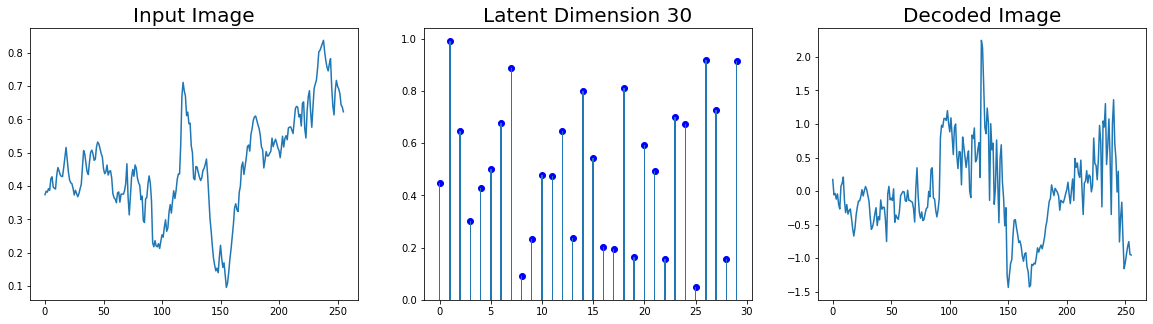

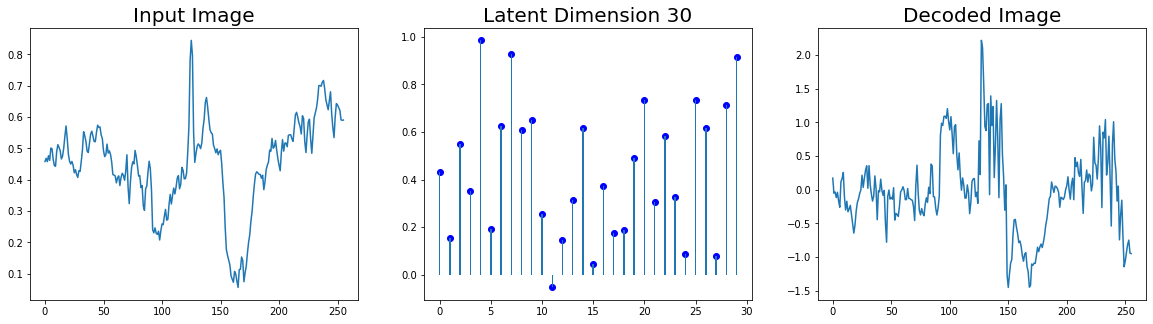

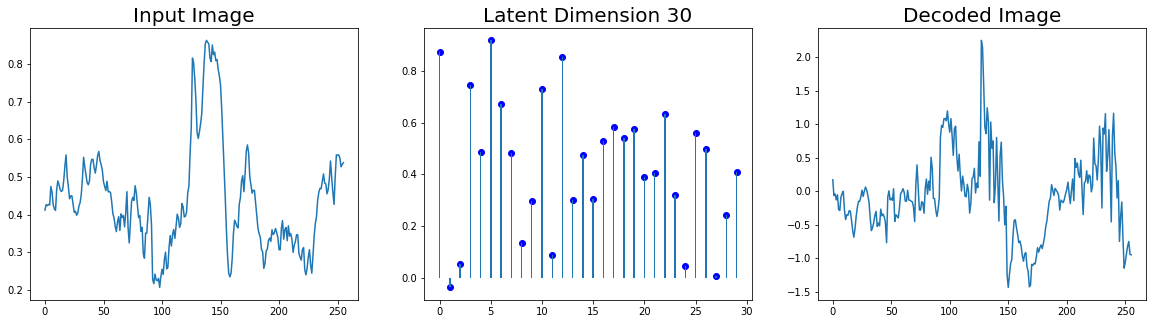

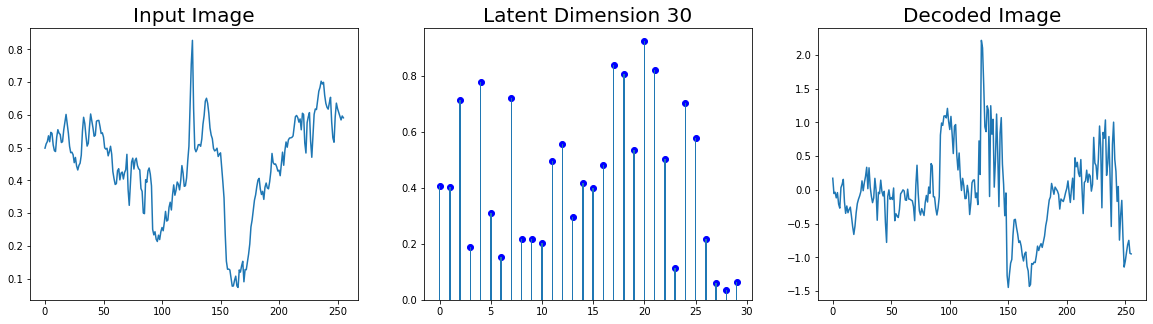

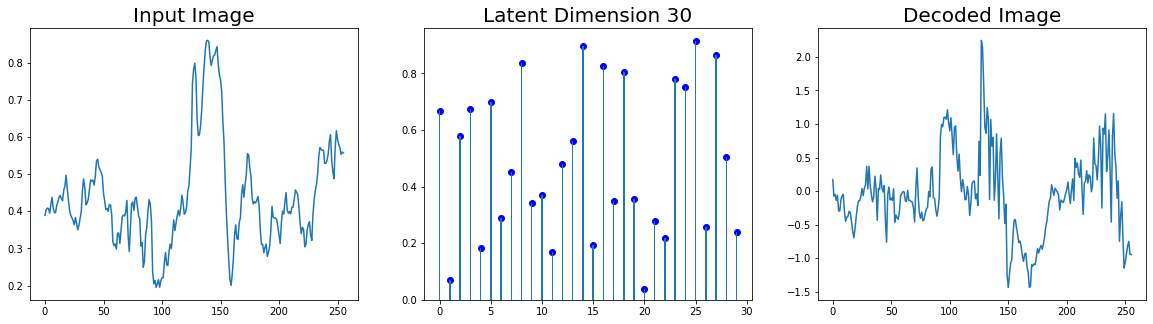

In [34]:
dataloader_iterator = iter(train_loader)
for i in range(10,15):
    try:
        img = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loader)
        img = next(dataloader_iterator)
    plot_encoding(img, model, ZDIMS)

In [35]:
# # def viz_latent_space(model, data):
# #   input_data, target_data = data
# #   mu, _ = model.encode(input_data)
# #   plt.figure(figsize=(8, 10))
# #   scatter = plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
# #   plt.xlabel('z - dim 1')
# #   plt.ylabel('z - dim 2')
# #   plt.legend(handles = scatter.legend_elements()[0],labels=  classes)
# #   plt.show()
# from sklearn.manifold import TSNE 
# latent_ecg = []
# target = []
# for data, targets in train_loader:
#     z_means, z_logvar = model.encode(data.permute(0,2,1).type(torch.cuda.FloatTensor))
#     # print(z_means.shape)
#     latent_ecg.extend(z_means.detach().cpu().numpy())
#     target.extend(targets.numpy())

# # take first 1k
# latent = np.array(latent_ecg)
# # print(latent.shape)
# target = np.array(target)
# tsne = TSNE(n_components=2, random_state=0, verbose=5, n_iter=500)

# X = tsne.fit_transform(latent_ecg)




In [36]:
# print(X.shape)

In [37]:
# plt.figure(figsize=(8,8))
# scatter = plt.scatter(X[:,0], X[:,1], c=target)
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('TSNE')
# plt.show()

In [38]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    kld_loss =0
    bce_loss =0
    recon_list = []
    z_list = []
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):
            # data = data[0]
            data = data.to(device)
            data = data.permute(0,2,1)
            # data_reshape = data.view(len(data), 1, 256).type(torch.cuda.FloatTensor)
            recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
            recon_list.append(recon_batch)
            z_list.append(Z)
            # print(recon_batch.shape)
            loss, kld, bce = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
            test_loss += loss.item()
            kld_loss += kld.item()
            bce_loss += bce.item()
            # print(">>>>>>", data.view(-1,256).shape)
            # if i % LOG_INTERVAL == 0:
    data_inv = scaler1.inverse_transform(data.view(-1,256).cpu().data.numpy())
    recon_batch_inv = scaler1.inverse_transform(recon_batch.view(-1,256).cpu().data.numpy())
    if(epoch==99):
      # n = min(data.size(0), 8)
      # comparison = torch.cat([data[:n], recon_batch[:n]])
      # print(comparison)
      # save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data_inv[:5]
      view_recon = recon_batch_inv[:5]

      for i in range(5):
          a[0][i].plot(view_data[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon[i])
      plt.show();
    test_loss /= len(test_loader.dataset)
    kld_loss /= len(test_loader.dataset)
    bce_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, kld_loss, bce_loss, recon_list, z_list

In [39]:
test_loss_list = []
kld_list_tst = []
bce_list_tst = []
for epoch in range(50):
    loss, kld_loss, bce_loss, recon_list, z_list_test = test(epoch)
    test_loss_list.append(loss)
    kld_list_tst.append(kld_loss)
    bce_list_tst.append(bce_loss)

====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0433
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss: 0.0435
====> Test set loss:

In [40]:
# f, a = plt.subplots(2, 5, figsize=(20,5))
# view_data = data[:5]
# view_recon = recon_batch[:5]

# for i in range(5):
#     a[0][i].plot(view_data[i])

# for i in range(5):
#     a[1][i].clear()
#     a[1][i].plot(view_recon[i])
# plt.show();

In [41]:
print(len(recon_list))
print(recon_list[0].shape)

27
torch.Size([64, 1, 256])


In [42]:
copy_recon = recon_list
recon_all = torch.cat(copy_recon, dim=0)
print(recon_all.shape)

torch.Size([1728, 1, 256])


In [43]:
recon_all_1 = torch.squeeze(recon_all, dim=1)
print(recon_all_1.shape)

torch.Size([1728, 256])


In [44]:
# sample from latent space

def sample_latent(model, no_samples):
  samples = []
  with torch.no_grad():
    for i in range(no_samples // 64):
      sample = torch.randn(64, ZDIMS).to(device)
      # print(sample.shape)
      sample = model.decode(sample).cpu()
      sample = scaler.inverse_transform(sample.view(-1,256).cpu().data.numpy())
      # sample = sample.permute(0,2,1)
      # print(sample.shape)
      samples.append(sample)
    return samples

In [45]:
samples = sample_latent(model,3000)
print(len(samples))

46


In [46]:
print(samples[0].shape)
all_samps = np.concatenate(samples, axis=0)
print(all_samps.shape)

(64, 256)
(2944, 256)


In [47]:
import os
sv_samps = '/content/drive/MyDrive/ecg/synthetic_data/conv_vae/beat_type' + str(num) + '.csv'
if not os.path.exists('/content/drive/MyDrive/ecg/synthetic_data/conv_vae'):
  os.makedirs('/content/drive/MyDrive/ecg/synthetic_data/conv_vae')
np.savetxt(sv_samps, all_samps, delimiter=',', fmt='%f')

In [48]:
def view_samples(sample):
  f, a = plt.subplots(1, 5, figsize=(40,5))
  view_data = sample[30:35]

  for i in range(5):
      a[i].plot(view_data[i])

      # for i in range(5):
      #     a[1][i].clear()
      #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
  plt.show();

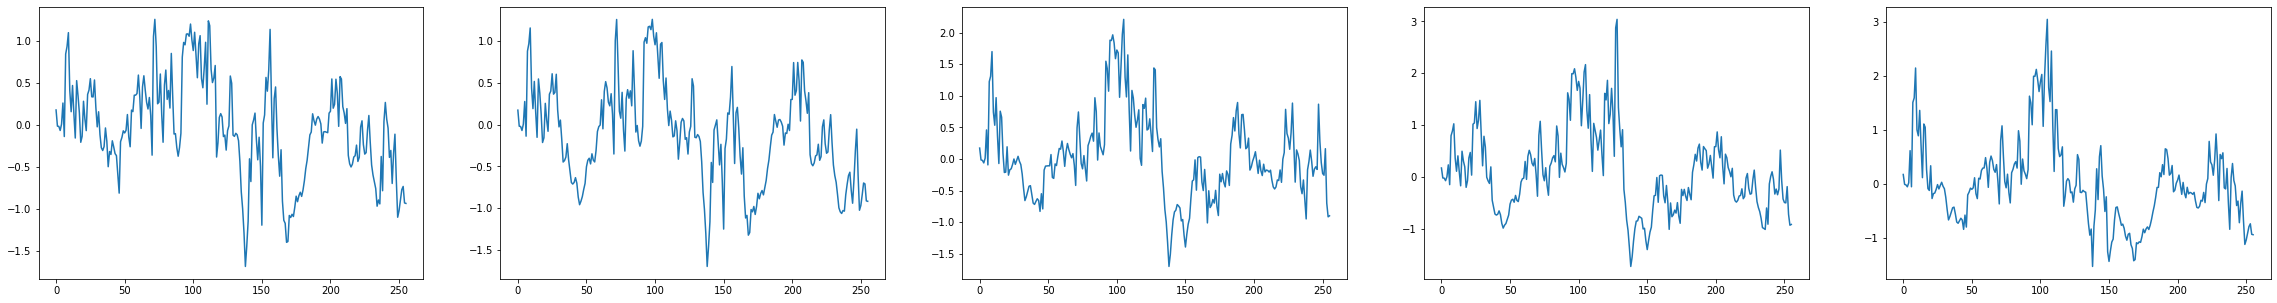

In [49]:
view_samples(all_samps)

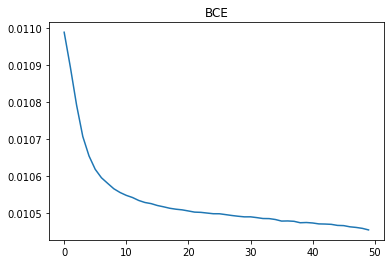

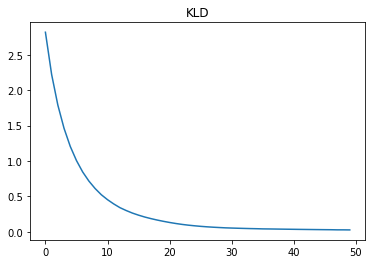

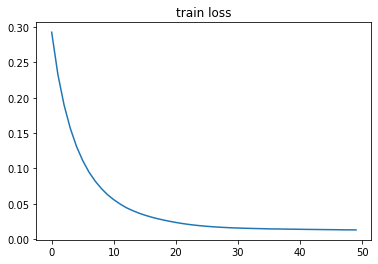

In [50]:
# loss graphs
# print(train_loss_list)
plt.plot(range(len(bce_list)), bce_list)
plt.title("BCE")
plt.show()
plt.plot(range(len(kld_list)), kld_list)
plt.title("KLD")
plt.show()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.title("train loss")
plt.show()

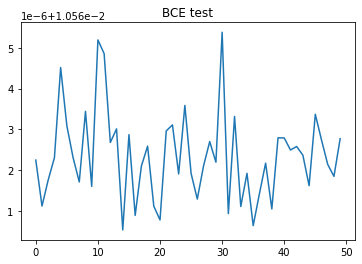

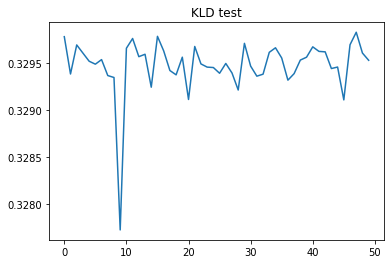

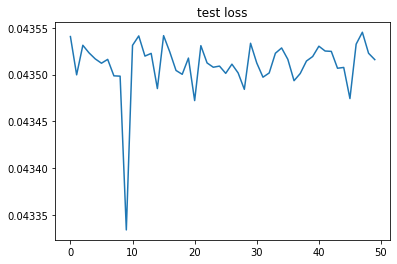

In [51]:
plt.plot(range(len(bce_list_tst)), bce_list_tst)
plt.title("BCE test")
plt.show()
plt.plot(range(len(kld_list_tst)), kld_list_tst)
plt.title("KLD test")
plt.show()
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("test loss")
plt.show()

In [52]:
### CLUSTERING
print(y_test.shape)

(1744,)


In [53]:
# data = recon_all_1.cpu().data.numpy()
# classes = y_test[:-7]
# print(classes.shape)

In [54]:
# from sklearn.decomposition import PCA
# x_pca = PCA(n_components=50,random_state=42).fit_transform(data)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA')

In [55]:
# from sklearn.manifold import TSNE
# x_tsne = TSNE(n_components=2,random_state=42,perplexity=100, verbose=5, n_iter=500).fit_transform(x_pca)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_tsne[:,0],x_tsne[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and TSNE')


In [56]:
# import umap
# reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=100, a = 0.5, b = 1.2)
# embedding = reducer.fit_transform(x_pca)
# embedding.shape
# plt.figure(figsize=(8,8))

# plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=classes, cmap='inferno')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and UMAP')